In [1]:
import pandas as pd
import uproot
import glob
import tqdm
import time

def xrootd_process(file):
    from XRootD import client
    from XRootD.client.flags import OpenFlags
    tick = time.time()
    with client.File() as f:
        status, response = f.open(file, OpenFlags.READ)
        status, data = f.read() # Reads the whole file
        server = f.get_property('DataServer')
    tock = time.time()
    elapsed = tock - tick
    return pd.DataFrame([{"server": server, "time": elapsed}])


directory = "/eos/purdue/store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/"
prefix = "root://eos.cms.rcac.purdue.edu//"
prefix_mount = "/eos/purdue/"

files = glob.glob(directory+"/**/*.root", recursive=True)
files = [f.replace(prefix_mount, prefix) for f in files]
print(len(files))

84


In [2]:
use_gateway = False

if use_gateway:
    from dask_gateway import Gateway
    gateway = Gateway()
    cluster = gateway.new_cluster(
        worker_memory = 8,
        queue = "cms",
        env={
            "WORKDIR": "/depot/cms/private/users/dkondra/af-benchmark",
            "X509_USER_PROXY": "/depot/cms/private/users/dkondra/x509up_u616617"
        }
    )
    cluster.scale(4)
    client = cluster.get_client()
    cluster
else:
    from distributed import LocalCluster, Client
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)

2024-02-27 17:23:25,591 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:43715 (pid=42570) exceeded 95% memory budget. Restarting...
2024-02-27 17:23:25,611 - distributed.nanny - WARNING - Restarting worker
2024-02-27 17:24:30,891 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:46039 (pid=42639) exceeded 95% memory budget. Restarting...
2024-02-27 17:24:30,913 - distributed.nanny - WARNING - Restarting worker
2024-02-27 17:24:59,741 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36355 (pid=42562) exceeded 95% memory budget. Restarting...
2024-02-27 17:24:59,762 - distributed.nanny - WARNING - Restarting worker
2024-02-27 17:25:45,240 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:39311 (pid=42693) exceeded 95% memory budget. Restarting...
2024-02-27 17:25:45,258 - distributed.nanny - WARNING - Restarting worker


In [4]:
df = pd.DataFrame(columns=["server", "time"])

futures = client.map(xrootd_process, files)
for f in futures:
    df = pd.concat([df,client.gather(f)])
df.reset_index(inplace=True)
df

,index,server,time
0,0,eos-a00.cms.rcac.purdue.edu:1101,3.084369
1,0,eos-b00.cms.rcac.purdue.edu:1101,3.378259
2,0,eos-a00.cms.rcac.purdue.edu:1103,6.804204
3,0,eos-c00.cms.rcac.purdue.edu:1102,4.540577
4,0,n000.cms.rcac.purdue.edu:1101,2.518268
...,...,...,...
79,0,eos-z00.cms.rcac.purdue.edu:1102,8.581713
80,0,l001.cms.rcac.purdue.edu:1101,7.698491
81,0,j001.cms.rcac.purdue.edu:1101,6.289176
82,0,k004.cms.rcac.purdue.edu:1101,8.199274


In [5]:
print("Average time spent reading a file")
df.groupby("server").mean().sort_values(by="time", ascending=False).drop("index", axis=1)

Average time spent reading a file


,time
server,
eos-a01.cms.rcac.purdue.edu:1101,45.561251
m000.cms.rcac.purdue.edu:1101,25.794430
eos-b00.cms.rcac.purdue.edu:1101,13.943353
eos-c00.cms.rcac.purdue.edu:1102,12.504581
k004.cms.rcac.purdue.edu:1101,12.175912
eos-a01.cms.rcac.purdue.edu:1102,11.470203
j001.cms.rcac.purdue.edu:1101,11.092805
eos-z01.cms.rcac.purdue.edu:1101,10.378211
eos-a00.cms.rcac.purdue.edu:1102,9.968050


In [6]:
print("Number of files read")
df.groupby("server").count().sort_values(by="time", ascending=False).drop("index", axis=1)

Number of files read


,time
server,
eos-a01.cms.rcac.purdue.edu:1102,9
eos-b00.cms.rcac.purdue.edu:1101,8
eos-b00.cms.rcac.purdue.edu:1102,5
eos-z00.cms.rcac.purdue.edu:1101,5
eos-z00.cms.rcac.purdue.edu:1102,5
eos-a00.cms.rcac.purdue.edu:1101,4
eos-c00.cms.rcac.purdue.edu:1101,4
eos-c00.cms.rcac.purdue.edu:1102,4
eos-c01.cms.rcac.purdue.edu:1101,4


<Axes: ylabel='Frequency'>

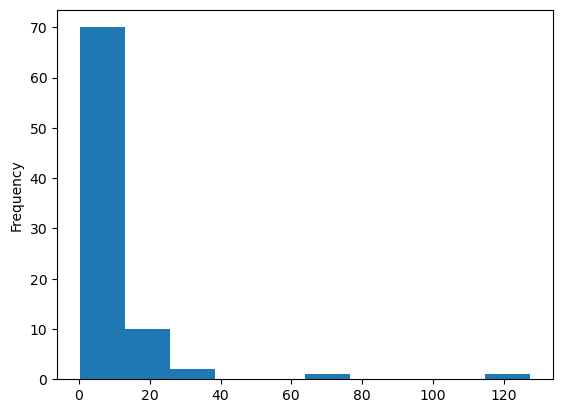

In [7]:
df.loc[:,"time"].plot.hist()